### Learning, Information and Knowledge Systems Lab, SEAS, Harvard University
### Hsiang Hsu
#### hsianghsu@g.harvard.edu

# Bottleneck Problem

**Fall 2017**<br/>
**Instructors**: Professor Flavio Calmon

---

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import math
import matplotlib
import matplotlib.pyplot as plt
from cvxpy import *
from tqdm import tqdm

from scipy.spatial import ConvexHull
from scipy.optimize import fsolve, linprog
from numpy.linalg import norm, inv, matrix_power
from scipy.integrate import simps
from scipy.linalg import sqrtm, svd

## Estimation Bottleneck - Sampling

In [30]:
''' Helper Functions '''
def stochastic_matrix(n, m):
    matrix = np.random.rand(n,m)
    return matrix/np.sum(matrix)

def random_channel(n, m):
    matrix = np.random.rand(n,m)
    return matrix/np.sum(matrix, 0)

def PIC(P_XY, P_X, P_Y):
    D_X_sqrtinv, D_Y_sqrtinv = np.diag(P_X**(-.5)), np.diag(P_Y**(-.5))
    Q = np.matmul(np.matmul(D_X_sqrtinv, P_XY), D_Y_sqrtinv)
    U, S, V = svd(Q)
    f, g = np.matmul(D_X_sqrtinv, U), np.matmul(D_Y_sqrtinv, V.transpose())
    pic = np.sqrt(S)
    return pic, f, g

def truncate_pic(pic, n_f):
    return np.diag(pic[0:n_f])

def sampling_A(nsamples, n_f, F):
    # initialize matrix A
    A = np.zeros((n_f,nsamples))

    for i in tqdm(range(nsamples)):
        # produce samples    
        a = 10*(2*np.random.rand(n_f,1)-1)

        # check if feasible resample
        while (F.dot(a)).min()< -1:
            a = 10*(2*np.random.rand(n_f,1)-1)

        A[:,i] = a[:,0]
    return A

def solve_maximization(nsamples, A, pic, beta, n_f):
    # produce constraints
    w = Variable(nsamples,1)
    constraints = []
    constraints.append(w>=0)
    constraints.append(sum(w)==1.0)
    constraints.append(A*w==0.0)
    
    # Cost Function
    pic_matrix = np.diag(pic[0:n_f])
    c = np.diag(np.dot(np.dot(A.transpose(), pic_matrix**2 - beta*np.identity(len(pic_matrix))), A))
    print(c.shape)
    
    # construct cvxpy optimization probem
    obj = Maximize(c.transpose()*w)
    prob = Problem(obj, constraints)
    
    # Solve the problem with cvxpy
    prob.solve()

    # optimal value
    optval = prob.value

    # produce optimal points
    wv = w.value

    # keep only values with significant contributions
    significant_index = np.ravel(wv >1e-8)

    Asig = A[:,significant_index]
    P_W = np.ravel(wv[significant_index])

    # normalize to avoid numerical issues
    P_W = P_W/sum(P_W)

    # P_{X|W} (g is for given)
    P_XgW = np.diag(P_X).dot(1+F.dot(Asig))

    # Produce joint distribution
    P_XW = P_XgW.dot(np.diag(P_W))

    # produce mapping from X to W
    P_WgX = np.diag(P_X**(-1)).dot(P_XW)
    
    return optval, P_WgX, P_XW, P_XgW, P_W

def solve_max_general(nsamples, F, A, beta, n_f, f, g):
    # produce constraints
    w = Variable(nsamples,1)
    constraints = []
    constraints.append(w>=0)
    constraints.append(sum(w)==1.0)
    constraints.append(A*w==0.0)
    
    # Cost Function
#     pic_matrix = np.diag(pic[0:n_f])
#     c = np.diag(np.dot(np.dot(A.transpose(), pic_matrix**2 - beta*np.identity(len(pic_matrix))), A))
    c = np.zeros((nsamples, 1))
    for i in range(nsamples):
        q = np.multiply(P_X, F.dot(A)[:, i]+1).reshape((len(P_X), 1))
        c[i] = phi(beta, f, g, P_X.reshape((len(P_X), 1)), P_Y.reshape((len(P_Y), 1)), q)
    
    # construct cvxpy optimization probem
    obj = Maximize(c.transpose()*w)
    prob = Problem(obj, constraints)
    
    # Solve the problem with cvxpy
    prob.solve()

    # optimal value
    optval = prob.value

    # produce optimal points
    wv = w.value

    # keep only values with significant contributions
    significant_index = np.ravel(wv >1e-8)

    Asig = A[:,significant_index]
    P_W = np.ravel(wv[significant_index])

    # normalize to avoid numerical issues
    P_W = P_W/sum(P_W)

    # P_{X|W} (g is for given)
    P_XgW = np.diag(P_X).dot(1+F.dot(Asig))

    # Produce joint distribution
    P_XW = P_XgW.dot(np.diag(P_W))

    # produce mapping from X to W
    P_WgX = np.diag(P_X**(-1)).dot(P_XW)
    
    return optval, P_WgX, P_XW, P_XgW, P_W

def solve_minimization(nsamples, A, pic, beta, n_f):
    # produce constraints
    w = Variable(nsamples,1)
    constraints = []
    constraints.append(w>=0)
    constraints.append(sum(w)==1.0)
    constraints.append(A*w==0.0)
    
    # Cost Function
    pic_matrix = np.diag(pic[-n_f:])
    c = np.diag(np.dot(np.dot(A.transpose(), pic_matrix**2 - beta*np.identity(len(pic_matrix))), A))
    
    # construct cvxpy optimization probem
    obj = Minimize(c.transpose()*w)
    prob = Problem(obj, constraints)
    
    # Solve the problem with cvxpy
    prob.solve()

    # optimal value
    optval = prob.value

    # produce optimal points
    wv = w.value

    # keep only values with significant contributions
    significant_index = np.ravel(wv >1e-8)

    Asig = A[:,significant_index]
    P_W = np.ravel(wv[significant_index])

    # normalize to avoid numerical issues
    P_W = P_W/sum(P_W)

    # P_{X|W} (g is for given)
    P_XgW = np.diag(P_X).dot(1+F.dot(Asig))

    # Produce joint distribution
    P_XW = P_XgW.dot(np.diag(P_W))

    # produce mapping from X to W
    P_WgX = np.diag(P_X**(-1)).dot(P_XW)
    
    return optval, P_WgX, P_XW, P_XgW, P_W

def solve_min_general(nsamples, F, A, beta, n_f, f, g):
    # produce constraints
    w = Variable(nsamples,1)
    constraints = []
    constraints.append(w>=0)
    constraints.append(sum(w)==1.0)
    constraints.append(A*w==0.0)
    
    # Cost Function
#     pic_matrix = np.diag(pic[-n_f:])
#     c = np.diag(np.dot(np.dot(A.transpose(), pic_matrix**2 - beta*np.identity(len(pic_matrix))), A))
    c = np.zeros((nsamples, 1))
    for i in range(nsamples):
        q = np.multiply(P_X, F.dot(A)[:, i]+1).reshape((len(P_X), 1))
        c[i] = phi(beta, f, g, P_X.reshape((len(P_X), 1)), P_Y.reshape((len(P_Y), 1)), q)
    
    # construct cvxpy optimization probem
    obj = Minimize(c.transpose()*w)
    prob = Problem(obj, constraints)
    
    # Solve the problem with cvxpy
    prob.solve()

    # optimal value
    optval = prob.value

    # produce optimal points
    wv = w.value

    # keep only values with significant contributions
    significant_index = np.ravel(wv >1e-8)

    Asig = A[:,significant_index]
    P_W = np.ravel(wv[significant_index])

    # normalize to avoid numerical issues
    P_W = P_W/sum(P_W)

    # P_{X|W} (g is for given)
    P_XgW = np.diag(P_X).dot(1+F.dot(Asig))

    # Produce joint distribution
    P_XW = P_XgW.dot(np.diag(P_W))

    # produce mapping from X to W
    P_WgX = np.diag(P_X**(-1)).dot(P_XW)
    
    return optval, P_WgX, P_XW, P_XgW, P_W

def Df_matrix(f, P, Q):
    result = 0
    for i in range(min(P.shape[0], Q.shape[0])):
        for j in range(min(P.shape[1], Q.shape[1])):
            if P[i, j] == 0:
                result = result
            elif Q[i, j] == 0:
                result = result
            else:    
                result = result + Q[i, j]*f(P[i, j]/Q[i, j])
    return result

def calculate_D(P_X, optval, P_W, P_XW, f, beta):
    P_X_P_W = np.dot(P_X.reshape((len(P_X), 1)), P_W.reshape((1, len(P_W))))
    D_XW = Df_matrix(f, P_XW, P_X_P_W)
    D_YW = optval + beta*D_XW
    return D_XW, D_YW

def phi(beta, f, g, P_X, P_Y, p):
    return Df_matrix(g, p, P_X) - beta*Df_matrix(f, p, P_Y)

def kronecker_BSC(T, ncascades):
    for i in range(ncascades):
        T = np.kron(T, T)
    return T

''' Common f-divergences '''
# KL Divergence
kl = lambda t: t*np.log2(t)
# Chi-squared Divergence
ci = lambda t: t**2 - 1
# Total Variation
tv = lambda t: 0.5*abs(t-1)
# Squared Hellinger 
sh = lambda t: (1-np.sqrt(t))**2

In [26]:
# Dimension Set-up
# n_x, n_y = 10, 8
# P_XY = stochastic_matrix(n_x,n_y)
# P_X, P_Y = P_XY.sum(axis=1), P_XY.sum(axis=0)

# BSC
px, delta = 0.1, 0.1
P_X = np.array([px, 1-px])
T = np.array([[1-delta, delta], [delta, 1-delta]])
P_Y = T.dot(P_X)
P_XY = P_X.reshape((len(P_X), 1)).dot(P_Y.reshape((1, len(P_Y))))
P_X = P_XY.sum(axis=1)
P_Y = P_XY.sum(axis=0)

# Kronecker BSC
# ncascades = 3
# n_x, n_y, delta = 2, 2, 0.1
# P_X = stochastic_matrix(n_x, 1)
# T = np.array([[1-delta, delta], [delta, 1-delta]])
# P_Y = np.dot(T, P_X)
# P_XY = P_X.reshape((len(P_X), 1)).dot(P_Y.reshape((1, len(P_Y))))
# P_XY = kronecker_BSC(P_XY, ncascades)
# P_X = P_XY.sum(axis=1)
# P_Y = P_XY.sum(axis=0)

# Construct the Channel
# T = np.dot(P_Y.reshape((n_y, 1)), (P_X**(-1)).reshape((1, n_x)))

# PIC decomposition
pic, f, g = PIC(P_XY,P_X,P_Y)

''' Generate samples '''
# number of dimensions and points
n_f = 1
# Principle Functions
F = f[:,1:n_f+1]

# generate samples
nsamples = 10**3
A = sampling_A(nsamples, n_f, F)

100%|██████████| 1000/1000 [00:00<00:00, 11106.06it/s]


In [18]:
''' Calculate Estimation Bottleneck '''
# regularization strength
nslopes = 101
betas = np.hstack((np.linspace(0, 1, nslopes), np.linspace(1, 20, nslopes)))

D_XW_max, D_YW_max = np.zeros((len(betas), 1)), np.zeros((len(betas), 1))
D_XW_min, D_YW_min = np.zeros((len(betas), 1)), np.zeros((len(betas), 1))

f1, f2 = kl, kl

for i in tqdm(range(len(betas))):
    beta = betas[i]
    ''' Estimation Bottleneck '''
#     optval, P_WgX, P_XW, P_XgW, P_W = solve_maximization(nsamples, A, pic, beta, n_f)
#     D_XW_max[i], D_YW_max[i] = calculate_D(P_X, optval, P_W, P_XW, ci, beta)
    
#     optval, P_WgX, P_XW, P_XgW, P_W = solve_minimization(nsamples, A, pic, beta, n_f)
#     D_XW_min[i], D_YW_min[i] = calculate_D(P_X, optval, P_W, P_XW, ci, beta)
    ''' General Case '''
    optval, P_WgX, P_XW, P_XgW, P_W = solve_max_general(nsamples, F, A, beta, n_f, f1, f2)
    D_XW_max[i], D_YW_max[i] = calculate_D(P_X, optval, P_W, P_XW, f1, beta)
    
    optval, P_WgX, P_XW, P_XgW, P_W = solve_min_general(nsamples, F, A, beta, n_f, f1, f2)
    D_XW_min[i], D_YW_min[i] = calculate_D(P_X, optval, P_W, P_XW, f1, beta)

100%|██████████| 202/202 [02:01<00:00,  1.67it/s]


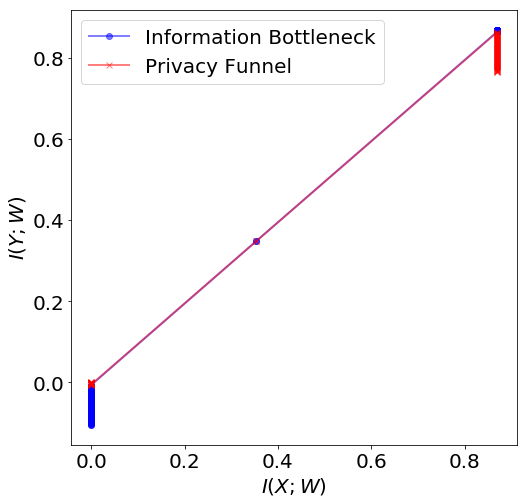

In [19]:
''' Visualization '''
fontsize = 20
linewidth = 2

plt.figure(figsize=(8, 8))
matplotlib.rcParams.update({'font.size': fontsize})
plt.plot(D_XW_max, D_YW_max, 'bo-', linewidth=linewidth, label=r'Information Bottleneck', alpha=0.5)
plt.plot(D_XW_min, D_YW_min, 'rx-', linewidth=linewidth, label=r'Privacy Funnel', alpha=0.5)
# plt.xlabel(r'$\chi^2(X; W)$', fontsize = fontsize)
# plt.ylabel(r'$\chi^2(Y; W)$', fontsize = fontsize)
plt.xlabel(r'$I(X; W)$', fontsize = fontsize)
plt.ylabel(r'$I(Y; W)$', fontsize = fontsize)
plt.legend(loc='best', fontsize = fontsize)

In [115]:
FA = np.multiply(P_X, F.dot(A)[:, 0]+1).reshape((len(P_X), 1))
FA.shape

(10, 1)

In [95]:
P_X.shape

(10,)

In [102]:
F.dot(A)[:, 0].shape

(10,)

In [116]:
FA.shape[1]

1

In [20]:
P_WgX

array([[  2.76515845e-03,   9.97234840e-01],
       [  9.99714775e-01,   2.85225888e-04]])

In [36]:
(D_YW_max<0).any()

True

In [27]:
Df_matrix(kl, P_X.reshape((len(P_X), 1)), P_Y.reshape((len(P_Y), 1)))

0.036071291884937018

## Flavio's Code

In [ ]:
n_x = 9
n_y = 8
P_XY = stochastic_matrix(n_x,n_y)
P_X = P_XY.sum(axis=1)
P_Y = P_XY.sum(axis=0)

pic, f, g = PIC(P_XY,P_X,P_Y)

In [ ]:
''' Generate samples '''
# number of dimensions and points
n_f = 3
F = f[:,1:n_f+1]

# generate samples
nsamples = 10**3

# initialize matrix A
A = np.zeros((n_f,nsamples))

for i in tqdm(range(nsamples)):
    # produce samples
    ###### TODO: improve this sampling procedure ######    
    a = 5*(2*np.random.rand(n_f,1)-1)
    
    # check if feasible resample
    while (F.dot(a)).min()< -1:
        a = 10*(2*np.random.rand(n_f,1)-1)
    
    A[:,i] = a[:,0]
    ##############################################

In [ ]:
# check values of A that we are obtaining
plt.hist(A.flatten(),bins=20)

In [ ]:
# check feasibility

# produce constraints
w = Variable(nsamples,1)
constraints = []
constraints.append(w>=0)
constraints.append(sum(w)==1.0)
constraints.append(A*w==0.0)

# produce random cost function
### !! Substitute this by true cost !!  ###
# c = np.random.rand(nsamples,1)
################################
beta = 1
pic_matrix = truncate_pic(pic, n_f)
c = np.diag(np.dot(np.dot(A.transpose(), pic_matrix**2 - beta*np.identity(len(pic_matrix))), A))


# construct cvxpy optimization probem
obj = Maximize(c.transpose()*w)
prob = Problem(obj, constraints)

In [ ]:
# Solve the problem with cvxpy
prob.solve()

# optimal value
optval = prob.value

# produce optimal points
wv = w.value

# keep only values with significant contributions
significant_index = np.ravel(wv >1e-8)

Asig = A[:,significant_index]
P_W = np.ravel(wv[significant_index])

# normalize to avoid numerical issues
P_W = P_W/sum(P_W)

# P_{X|W} (g is for given)
P_XgW = np.diag(P_X).dot(1+F.dot(Asig))

# Produce joint distribution
P_XW = P_XgW.dot(np.diag(P_W))

# produce mapping from X to W
P_WgX = np.diag(P_X**(-1)).dot(P_XW)

In [ ]:
optval

In [ ]:
P_WgX

## Mrs. and Mr. Gerber's Lemma

In [ ]:
''' Helper Functions '''
# Binary Entropy Function
def hb(p):
    if p == 0 or p == 1:
        return 0
    else:
        return -p*np.log2(p)-(1-p)*np.log2(1-p)

# Binary Entropy Inverted Function
def hbv(h):
    f = lambda x: x**x * (1-x)**(1-x) - 2**(-h)
    return fsolve(f, 0)

# Complement Multiplication Operator
def star(a, b):
    return (1-a)*b+(1-b)*a


def MSGL_L(x, delta):
    return hb(star(delta, hbv(x)))
def MSGL_U(x, delta, q):
    f = lambda a: x- a*hb(q/max(a, 2*q))
    a = fsolve(f, 0.5)
    return a*hb(star(q/max(a, 2*q), delta)) + (1-a)*hb(delta)
    

In [ ]:
# crossover probability
delta = 0.4
#
q = 0.01

x = np.linspace(0, hb(q), 51)
MSGL_upper = []
MSGL_lower = []
for i in range(len(x)):
    MSGL_upper.append(MSGL_U(x[i], delta, q)[0])
    MSGL_lower.append(MSGL_L(x[i], delta)[0])
plt.figure(figsize=(8, 8))
plt.plot(x, MSGL_upper, 'b-', label='$\max\ H(Y|W)$', linewidth=3)
plt.plot(x, MSGL_lower, 'r-', label='$\min\ H(Y|W)$', linewidth=3)
plt.fill_between(x, MSGL_lower, MSGL_upper, color='gray', label='Achievable Regions')
plt.xlabel('$H(X|W)$', fontsize = 15)
plt.ylabel('$H(Y|W)$', fontsize = 15)
plt.legend(loc='best', fontsize=15)

In [ ]:
# crossover probability
delta = 0.1
# 
q = 0.1

x = np.linspace(0, hb(q), 51)
I_WX = []
I_WY_min = []
I_WY_max = []
for i in range(len(x)):
    I_WX.append(hb(q) - x[i])
    I_WY_min.append(hb(star(q, delta)) - MSGL_U(x[i], delta, q))
    I_WY_max.append(hb(star(q, delta)) - MSGL_L(x[i], delta))
 
plt.figure(figsize=(8, 8))
plt.plot(I_WX, I_WY_min, 'b-', label='Privacy Funnel')
plt.plot(I_WX, I_WY_max, 'r-', label='Information Bottleneck')
plt.xlabel('$I(W; X)$', fontsize = 15)
plt.ylabel('$I(W; Y)$', fontsize = 15)
plt.legend(loc='best', fontsize=15)
plt.title('BSC with Crossover Probability %.2f and P(X=1) = %.2f'%(delta, q), fontsize=15)

## IB and PF in $\chi^2$ divergence

In [ ]:
def D(func, p, q):
    return q*func(p/q) + (1-q)*func((1-p)/(1-q))
def star(a, b):
    return (1-a)*b+(1-b)*a
def phi(func, lambda_, p, qx, qy, delta):
    return D(func, star(p, delta), qy) - lambda_*D(func, p, qx)

kl = lambda t: t*np.log2(t)
ci = lambda t: (t-1)**2

f, g = ci, ci

number_of_samples = 11
X = np.linspace(0, 0.9, number_of_samples)
number_of_slopes = 11
lambdas = np.linspace(0, 20, number_of_slopes)
p = np.linspace(0, 1, number_of_samples)

qx = 0.1
delta = 0.1
qy = star(qx, delta)
L_T = []
U_T = []

for i in range(number_of_samples):
    x = X[i]
    objective_L, objective_U = [], []
    Phi = []
    for j in range(number_of_slopes):
        lambda_ = lambdas[j]
        for k in range(number_of_samples):
            Phi.append(phi(f, lambda_, p[k], qx, qy, delta))
        if Phi[round(number_of_samples/2)] < 0.5*Phi[0]+0.5*Phi[-1]:
            pxi_L = phi(f, lambda_, qx, qx, qy, delta)
            pxi_U = (Phi[-1]-Phi[0])*qx + Phi[0]
        else:
            pxi_L = (Phi[-1]-Phi[0])*qx + Phi[0]
            pxi_U = phi(f, lambda_, qx, qx, qy, delta)
        objective_L.append(pxi_L+lambda_*x)
        objective_U.append(pxi_U+lambda_*x)
    L_T.append(max(objective_L))
    U_T.append(min(objective_U))

In [ ]:
fig = plt.figure(figsize=(5, 5))
plt.plot(X, L_T, 'b.-', alpha=0.3)
plt.plot(X, U_T, 'r.-', alpha=0.3)
plt.fill_between(X, L_T, U_T, color= 'gray', alpha=0.7)

## Generalized Mrs. and Mr. Gerber's Lemma

In [ ]:
''' Helper Functions '''
# Binary Entropy Function
def hb(p):
    if p == 0 or p == 1:
        return 0
    else:
        return -p*np.log2(p)-(1-p)*np.log2(1-p)

# Binary Entropy Inverted Function
def hbv(h):
    f = lambda x: x**x * (1-x)**(1-x) - 2**(-h)
    return fsolve(f, 0)

# Complement Multiplication Operator
def star(a, b):
    return (1-a)*b+(1-b)*a

# Mr./Mrs. Gerber's Lemma
def MSGL_L(x, delta):
    return hb(star(delta, hbv(x)))
def MSGL_U(x, delta, q):
    f = lambda a: x- a*hb(q/max(a, 2*q))
    a = fsolve(f, 0.5)
    return a*hb(star(q/max(a, 2*q), delta)) + (1-a)*hb(delta)

# Renyi Entropy
def Hb(b, P_X):
    sum_ = 0
    for i in range(len(P_X)):
        sum_ = sum_ + P_X[i]**b
    return 1/(1-b)*np.log(sum_)
def Kb(b, P_X):
    return np.exp((1-b)/b*Hb(b, P_X))

# Generalized Mr./Mrs. Gerber's Lemma
def GMRGL(x, q, delta, b):
    f = lambda a: Kb(b, [a, 1-a])-x
    p = fsolve(f, 0.5)
    return Kb(b, [star(p, delta), star(1-p, delta)])
def GMSGL(x, q, delta, b):
    f = lambda a: (1-a) + a*Kb(b, [q/max(a, 2*q), 1-q/max(a, 2*q)]) - x
    a = fsolve(f, 0.5)
    return a*Kb(b, [star(q/max(a, 2*q), delta), 1-star(q/max(a, 2*q), delta)]) + (1-a)*Kb(b, [delta, 1-delta])

In [ ]:
''' Setting Up '''
# Pr(X=1) = q
q = 0.4
# Crossover Probability \delta
delta = 0.2
# Order
B = [2, 5, 10]
# Resolution of the Image
n_sample = 51

P_X = [q, 1-q]
P_Y = [star(q, delta), star(1-q, delta)]
Ib_XW, Ib_YW_min, Ib_YW_max = \
     np.zeros((len(B)+1, n_sample)), np.zeros((len(B)+1, n_sample)), np.zeros((len(B)+1, n_sample))

figure_description = 'BSC_MGL.eps'

''' Mr./Mrs. Gerber's Lemma '''
H_X = np.linspace(0, hb(q), n_sample)    
for i in range(n_sample):
    x = H_X[i]
    Ib_XW[0][i] = hb(q) - x
    Ib_YW_min[0][i] = hb(star(q, delta)) - MSGL_U(x, delta, q)
    Ib_YW_max[0][i] = hb(star(q, delta)) - MSGL_L(x, delta)
    
plt.figure(figsize=(8, 8))
matplotlib.rcParams.update({'font.size': 15})
plt.plot(Ib_XW[0, :], Ib_YW_min[0, :], 'b-', linewidth=1, label='Generalized MRGL')
plt.plot(Ib_XW[0, :], Ib_YW_max[0, :], 'r-', linewidth=1, label='Generalized MGL')
plt.fill_between(Ib_XW[0, :], Ib_YW_min[0, :], Ib_YW_max[0, :], color='gray', label=r'$\beta = $%d'%1, alpha=0.7)
    
''' Generalized Mr./Mrs. Gerber's Lemma '''
C = ['orange', 'green', 'purple']
for j in range(1, len(B)+1):
    b = B[j-1]
    Hb_X = Hb(b, P_X)
    Hb_Y = Hb(b, P_Y)
    Kb_XgW = np.linspace(Kb(b, P_X), 1, n_sample)
    for i in range(n_sample):
        x = Kb_XgW[i]
        Ib_XW[j][i] = Hb_X - b/(1-b)*np.log(x)
        Ib_YW_min[j][i] = Hb_Y - b/(1-b)*np.log(GMRGL(x, q, delta, b)[0])
        Ib_YW_max[j][i] = Hb_Y - b/(1-b)*np.log(GMSGL(x, q, delta, b)[0])

#     plt.plot(Ib_XW[j, :], Ib_YW_min[j, :], 'b-', linewidth=1)
#     plt.plot(Ib_XW[j, :], Ib_YW_max[j, :], 'r-', linewidth=1)
    plt.fill_between(Ib_XW[j, :], Ib_YW_min[j, :], Ib_YW_max[j, :], color=C[j-1], label=r'$\beta = $%d'%b, alpha=0.7)

plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.xlabel(r'$I_\beta(W; X)$', fontsize = 15)
plt.ylabel(r'$I_\beta(W; Y)$', fontsize = 15)
plt.legend(loc='lower right', fontsize=15)
plt.savefig('Figures/%s'%figure_description, format='eps', dpi=1000)

## Integrate All the Figures

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(27, 8))
fontsize = 20
linewidth = 2
matplotlib.rcParams.update({'font.size': fontsize})

figure_description = 'ISIT18.eps'

ax[0].plot(I_WX, I_WY_max, 'r-', linewidth=linewidth, label=r'$\mathsf{IB}(P_{XY}, x)$')
ax[0].plot(I_WX, I_WY_min, 'b--', linewidth=linewidth, label=r'$\mathsf{PF}(P_{XY}, x)$')
ax[0].set_xlabel('$I(W; X)$', fontsize = fontsize)
ax[0].set_ylabel('$I(W; Y)$', fontsize = fontsize)
ax[0].legend(loc='best', fontsize=fontsize)

ax[1].plot(X, U_T, 'r-', linewidth=linewidth, label=r'$\mathsf{IB}_{\chi^2}(P_{XY}, x)$')
ax[1].plot(X, L_T, 'b--', linewidth=linewidth, label=r'$\mathsf{PF}_{\chi^2}(P_XY, x)$')
ax[1].set_xlabel(r'$\chi^2(W; X)$', fontsize = fontsize)
ax[1].set_ylabel(r'$\chi^2(W; Y)$', fontsize = fontsize)
ax[1].legend(loc='best', fontsize=fontsize)

# ax[2].plot(Ib_XW[0, :], Ib_YW_min[0, :], 'b-', linewidth=2, label='Generalized MRGL')
# ax[2].plot(Ib_XW[0, :], Ib_YW_max[0, :], 'r-', linewidth=2, label='Generalized MGL')
ax[2].fill_between(Ib_XW[0, :], Ib_YW_min[0, :], Ib_YW_max[0, :], color='gray', label=r'$\beta = $%d'%1, alpha=0.7)
for j in range(1, len(B)+1):
    b = B[j-1]
    ax[2].fill_between(Ib_XW[j, :], Ib_YW_min[j, :], Ib_YW_max[j, :], color=C[j-1], label=r'$\beta = $%d'%b, alpha=0.7)
ax[2].set_xlim(xmin=0)
ax[2].set_ylim(ymin=0)
ax[2].set_xlabel(r'$I_\beta(W; X)$', fontsize = fontsize)
ax[2].set_ylabel(r'$I_\beta(W; Y)$', fontsize = fontsize)
# ax[2].legend(loc='lower right', fontsize=15)
ax[2].text(0.2, 0.25, r'$\beta=10$', color='purple')
ax[2].text(0.6, 0.35, r'$\beta=5$', color='green')
ax[2].text(0.6, 0.25, r'$\beta=2$', color='orange')
ax[2].text(0.8, 0.20, r'$\beta=1$', color='gray')
plt.savefig('Figures/%s'%figure_description, format='eps', dpi=1000, bbox_inches='tight')